# Windowing

Goal: Use windowing of a time-domain signal to improve the signal clarity. 

Real signals are typically acquired such that the end-points are discontinuous. These artificial discontinuities show up in the frequency spectrum as high-frequency components not present in the original signal. These components can occur at much higher frequency values than the Nyquist limit and are aliased, resulting in spectral leakage (see the spectra below as an example). 

To reduce the amplitude of the discontinuities at the boundaries and avoid spectral leakage, we can apply a window to the time-domain signal prior to taking its FFT.  

### Packages

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.signal as signal
from   scipy.fftpack import fft, fftshift
import numpy as np
import math

In [3]:
# function for calculating next power of 2 of val x (use for zero-padding)
def nextpow2(x):
    ''' 
    calculate the next power of 2 of x
    '''
    return (x-1).bit_length()


## Time-domain signal $y(t)$ and its frequency spectrum $Y(f)$ via Fourier transform 

Lets generate a time-domain signal $y(t)$ that we can later use for analysis. Also, lets look at its frequency spectrum $Y(f)$. The frequency spectrum is effectively windowed using a rectangular window of unity amplitude. 

For this signal, we specify a central freqeuncy lobe at $f_0$ (5 Hz) and additional peaks at 0.8, 1.25, and 1/3 times $f_0$ (4, 6.25, and 1.66 Hz, respectively). 

In the frequency spectrum, the defined peaks are evident. However, there are notable lobes in between these peaks at elevated levels. To remove/reduce these artificial peaks, we can window the original signal using a window function defined and multiplied in the time domain. 

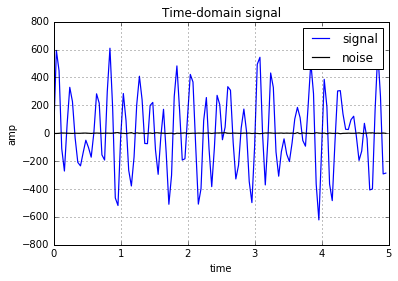

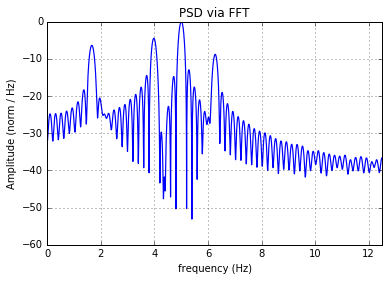

In [14]:
'''
time signal calculation (w\ and w\o noise)
'''
# INPUT parameter
f0 = 5;    # center freq of primary component of signal
amp = 300;  # amplitude of primary component
# calcualted paramters -------------------------------
Fs = 5*f0 # sampling frequency 
t = np.arange(0,float(f0),float(1/Fs))# time vector
# signal y(t):
y = amp*np.sin(2 * np.pi * f0 * t) + \
    amp/1.7*np.sin(2 * np.pi * f0/1.25 * t) + \
    amp/3*np.sin(2 * np.pi * f0*1.25 * t) + \
    amp/2*np.sin(2 * np.pi * f0/3 * t)       
# zero-sum noise added to signal
noise = np.random.normal(0,1.5,len(t)) # noise
y = y + noise # signal plus noise

# plot -------------------------------
plt.plot(t, y,'b-',linewidth=1.2, label='signal')
plt.plot(t, noise,'k-',linewidth=1.2, label='noise')
plt.xlabel('time')
plt.ylabel('amp')
plt.title('Time-domain signal')
plt.legend(loc='upper right')
plt.grid()
plt.show()
len(t)

#+++++++++++++++++++++++++++++++++++++++++++++++
''' 
frequency spectrum using FFT
'''
# fft of signal---------------
Y = np.fft.fft(y, 4**nextpow2(len(y))) # fft of y 
Y = np.abs(Y)**2  # square the abs value of Y
Y = (Y/max(Y))    # normalize to max val

freq1  = np.linspace(0,Fs,len(Y)) # freq vec for non-zero pad signal


# plot on log scale --------------------
plt.plot(freq1, 10*np.log10(Y), 'b-',linewidth=1.2)
plt.ylabel('Amplitude (norm / Hz)')
plt.xlabel('frequency (Hz)')
plt.title('PSD via FFT')
plt.xlim([0,Fs/2])
plt.grid()
plt.show()

## Define window

Function `winSpec` for calculating window paramters. Here, the parameters are specified for a Hanning, Hamming, Blackman and a continuous third derivative. Specs can be changed to make any window you want.

In [15]:
# Specify paramters-----------------------------------------
method= 'Hanning','Hamming','Blackman', 'Continuous third deriv'
a =      0.5,     0.54,      0.42,        0.375
b =      0.5,     0.46,      0.50,        0.5
c =      0   ,    0   ,      0.08,        0.125
n = len(t)

#-----------------------------
def winSpec(a,b,c,n):
    N = np.arange(0,n,1)
    if n > 1:
        w = a - b*np.cos(2*np.pi*N/n) + c*np.cos(4*np.pi*N/n);
    elif n == 1:
        w = 1;
    else:
        print('N must be greater than 0')
    return w, N

##  Time- and frequency-domain response of window function
Time-domain response of various windows calculated using `winSpec` and comparison with Hammin window provided by scipy

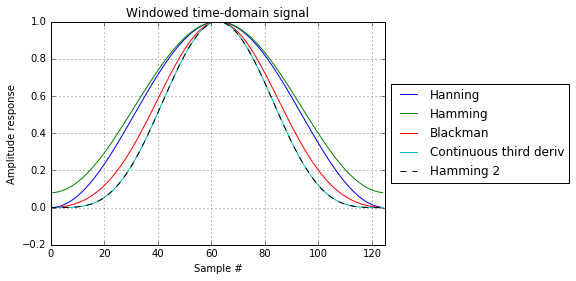

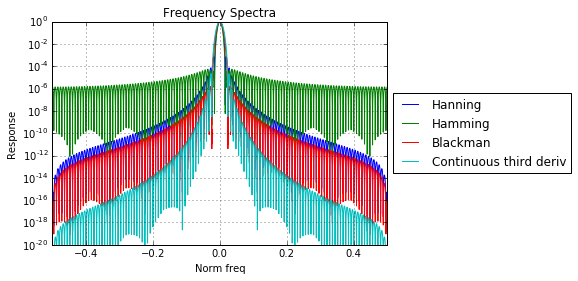

In [16]:
for i in range(len(a)):
    #--------------------------------------------------
    # window function using defined parameters a, b, c, & n
    window2,N = winSpec(a[i],b[i],c[i],n)
    # plot in time-domain
    plt.figure(1)
    plt.plot(window2,label = method[i])
    plt.legend(loc='upper right')
    #--------------------------------------------------
    # frequency spectrum of windowed signal ----------
    A = fft(window2, 4**nextpow2(len(window2))) # fft w\ zero padding
    A = (A*2.0/len(A)) # normalize
    A = abs(A/A.max())**2
    A = fftshift(A)    # shift fft
    # freq vector
    freq = np.linspace(-0.5, 0.5, len(A))
    # plot
    plt.figure(2)
    plt.semilogy(freq, (A), label = method[i])
    
# for comparison/validation
plt.figure(1)
windowHamm = signal.hamming(n)
plt.plot(window2,'k--',label = 'Hamming 2')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Sample #')
plt.ylabel('Amplitude response')
plt.title('Windowed time-domain signal')
plt.xlim(0, len(t))
plt.grid()

plt.figure(2)
plt.xlim(-.5, .5)
plt.ylim(10**-20, 10**0)
plt.xlabel('Norm freq')
plt.ylabel('Response')
plt.title('Frequency Spectra')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

### Example of window applied to our original signal: 
Note the endpoints are no are smoothed to zero and are no longer discontinuous. 

(0, 125)

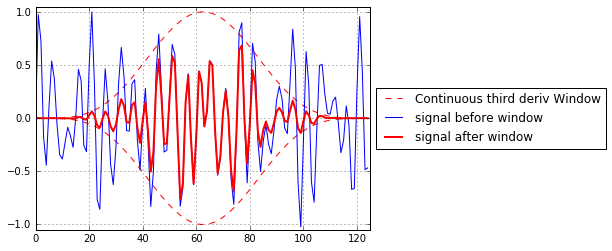

In [11]:
iMethod = 3
windowExample,N = winSpec(a[iMethod],b[iMethod],c[iMethod],len(y))

plt.figure(1)
plt.plot(windowExample,'r--')
plt.plot(-windowExample,'r--',label=(method[iMethod] + ' Window'))
plt.plot(y/max(y),'b-', label = 'signal before window')
plt.plot(y/max(y)*windowExample,'r-', linewidth=2,label='signal after window')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(-1.05,1.05)
plt.xlim(0,len(y))


## Comparison of  window methods applied to signal

Apply various window functions to the original signal (multiply in time-domain) and plot frequency spectra of each. Note the reduction of sidelobes for each window. Also, the relative amplitude of the known peak spectral components are unchanged. 

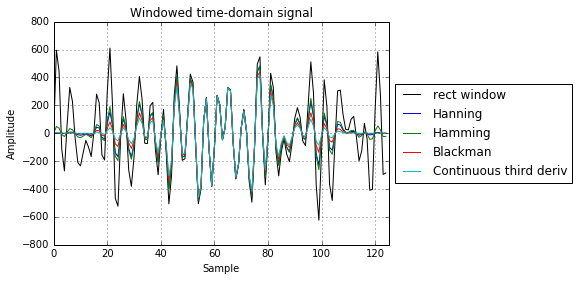

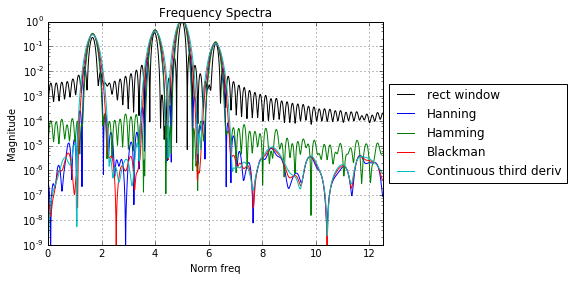

In [13]:
# plot original signal and spectra:
plt.figure(1)
plt.plot(y, 'k', label='rect window')
plt.figure(2)
plt.semilogy(freq1, Y, 'k', label='rect window')

# window original signal, calculate frequency spectra
for i in range(len(a)):
    #--------------------------------------------------
    # window function using defined parameters a, b, c, & n
    window2,N = winSpec(a[i],b[i],c[i],len(y))
    #--------------------------------------------------
    # window time-domain signal -----------------------
    Y2 = window2*y
    # plot
    plt.figure(1)
    plt.plot(Y2, label = method[i])
    #--------------------------------------------------
    # frequency spectrum of windowed signal ----------
    A2 = (fft(Y2, 4**nextpow2(len(Y2))))/(len(window2)/2.0)
    A2 = abs(A2)/A2.max()
    A2 = (A2**2)
    # plot
    freq2  = np.linspace(0,Fs,len(A2)) 
    plt.figure(2)
    plt.semilogy(freq2, abs(A2), label = method[i])
    
# plot parameters
plt.figure(1)
plt.xlim(0, len(y))
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Windowed time-domain signal')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

plt.figure(2)
plt.xlabel('Norm freq')
plt.ylabel('Magnitude')
plt.title('Frequency Spectra')
plt.xlim(0, Fs/2)
plt.ylim(10**-9, 10**0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

